# Data Story

In [27]:
import sys
import os

database_path = '../'

print(sys.path)

def import_system_path():
    if database_path not in sys.path:
        sys.path.append(database_path)
        print('New path added to Sys.')
    else:
        print('Path already exists.')
        
import_system_path()

['C:\\Users\\simon\\Desktop\\FS2020-Project-Climate-Change\\storytelling', 'C:\\Users\\simon\\anaconda3\\python37.zip', 'C:\\Users\\simon\\anaconda3\\DLLs', 'C:\\Users\\simon\\anaconda3\\lib', 'C:\\Users\\simon\\anaconda3', '', 'C:\\Users\\simon\\anaconda3\\lib\\site-packages', 'C:\\Users\\simon\\anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\simon\\anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\simon\\anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\simon\\anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\simon\\.ipython', '../']
Path already exists.


In [28]:
import numpy as np
import pandas as pd

import re

import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import datapackage

from database.get_db_data import DataAccess

In [29]:
da = DataAccess()
df_global = da.get_global_data_db()
df_swiss = da.get_swiss_data_db()
print(df_global.keys())
print(df_swiss.keys())

dict_keys(['temperature', 'co2'])
dict_keys(['precipitation', 'new_snow', 'sunshine', 'temperature'])


In [30]:
def extract_dataframes_swiss(df_dict):
    """"""
    swiss_keys = list(df_dict.keys())
    
    prec = df_dict[swiss_keys[0]]    
    snow = df_dict[swiss_keys[1]]    
    sunshine = df_dict[swiss_keys[2]]    
    temp = df_dict[swiss_keys[3]]
    
    return prec, snow, sunshine, temp


def extract_dataframes_global(df_dict):
    """"""
    global_keys = list(df_dict.keys())
    
    temp = df_dict[global_keys[0]]    
    co2 = df_dict[global_keys[1]]
    
    return temp, co2

In [31]:
swiss_precipitation, swiss_snow, swiss_sunshine, swiss_temp = extract_dataframes_swiss(df_swiss)
temp_data, co2_data = extract_dataframes_global(df_global)

In [32]:
def swiss_places_column_titles(data):
    """Replaces the Header of the swiss data table with only alphabetic chars."""
    new_cols = []
    
    for i in data.columns:
        result = re.sub("[1,2) ]", '', i)
        new_cols.append(result)
    data.columns = new_cols
    
    return data  


def get_continents(global_data):
    
    global_data = global_data.copy()
    
    data_url = 'https://datahub.io/JohnSnowLabs/country-and-continent-codes-list/datapackage.json'

    package = datapackage.Package(data_url)

    resources = package.resources
    for resource in resources:
        if resource.tabular:
            continent_data = pd.read_csv(resource.descriptor['path'])
    continent_data = continent_data[['Continent_Name', 'Three_Letter_Country_Code']]
    
            
    global_data = pd.merge(left=continent_data, right=global_data, how='inner',
                           left_on='Three_Letter_Country_Code', right_on='alpha_3').drop('Three_Letter_Country_Code',
                                                                                             axis=1)
    if global_data.columns[-1] == 'temperature':
        global_data.columns = ['continent','date','country','alpha_3','temperature']
    elif global_data.columns[-1] == 'co2':
        global_data.columns = ['continent','date','country','alpha_3','co2']
    
    return global_data

In [33]:
co2_data = get_continents(co2_data)
temp_data = get_continents(temp_data)

Jan geht jeden Winter  zu seiner Grossmutter in die Skiferien nach Davos. Seine Grossmutter lebt bereits ihr ganzes Leben im Davoser-Dorf. Immer wieder tönt sie an, es gäbe von Jahr zu Jahr immer weniger Schnee im Dorf und auch im Skigebiet. Hat sich seine Grossmutter das nur ausgedacht oder steckt da wirklich einen Funken Wahrheit dahinter.
Jan ist sehr faktenorientiert und möchte sich dies einmal genauer ansehen. Er recherchiert...

Jan findet eine Infografik über die jährliche gemessene Schneehöhe in Davos-Klosters.

In [34]:
def lineplot_davos_snow(data):
    
    data = data.copy().pivot_table(columns='region', index='year', values='new_snow')
    
    data = swiss_places_column_titles(data)

    data = data['DavosWSL']
    new_val = np.where(data == '...' ,None , data*1)
    data = pd.DataFrame(new_val, index=data.index).dropna().astype('int')
    
    data = data - data.iloc[0]
    data.loc[:,'color'] = np.where(data >= 0, 1, 0)
    data.columns = ['snow', 'color']
    data.index = pd.to_numeric(data.index)
  
    fig = px.bar(x=data.index, 
                 y=data['snow'], 
                 color=data['color'], 
                 title='Jährliche Abweichungen Neuschnee zu {} in Davos von {} bis {}'.format(data.index[0], data.index[0], data.index[-1]),
                 labels={'x':'Jahre', 'y':'Abweichung Neuschnee pro Jahr (cm)'},  
                 template='simple_white',
                 color_continuous_scale=['red', 'blue'],
                 opacity=0.7
            )
    
    fig.update(layout_coloraxis_showscale=False)
    fig.show()
     
lineplot_davos_snow(swiss_snow)

C:\Users\simon\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [35]:
def lineplot_davos_snow(data):
    
    data = data.copy().pivot_table(columns='region', index='year', values='new_snow')
    
    data = swiss_places_column_titles(data)
    data = data['DavosWSL']
    new_val = np.where(data == '...' ,None , data*1)
    data = pd.DataFrame(new_val, index=data.index).dropna().astype('int')
    
    data = data - data.iloc[0]
    data.loc[:,'color'] = np.where(data >= 0, 1, 0)
    data.columns = ['snow', 'color']
    data.index = pd.to_numeric(data.index)
  
    fig = px.scatter(x=data.index, 
                     y=data['snow'], 
                     color=data['color'], 
                     trendline='ols',
                     title='Jährliche Abweichungen Neuschnee zu {} in Davos von {} bis {}'.format(data.index[0], data.index[0], data.index[-1]),
                     labels={'x':'Jahre', 'y':'Abweichung Neuschnee pro Jahr (cm)'},  
                     template='simple_white'  
                     )
    
    fig.update_traces(mode='lines')
    fig.update(layout_coloraxis_showscale=False)
    fig.show()
     
lineplot_davos_snow(swiss_snow)

Jan verfolgt den Trend und merkt, dass es seit 1960 immer weniger schneereiche Jahre gibt. Er möchte das prüft den Trend in dem er eine Lineare Regression über den Trend legt. Der Trend der Regressionslinie zeigt nach unten, was darauf hindeutet, dass es wirklich immer weniger Schnee in Davos gibt. Er findet eine weitere Grafik, welche die jährliche Durchschnittstemperatur präsentiert. 

Die Globale Temperatur nimmt zu. Dies ist ein Fakt, der jedem bewusst ist. Wie sieht die Zunahme der Temperatur von der Schweiz und der übrigen Ländern aus?

In [36]:
def lineplot_swiss_global_temp(data):
    data = data.copy()
    
    data = data.pivot_table(index='date', columns='country', values='temperature')
    data.index = pd.to_datetime(data.index)
    
    data = data.loc['1800':]
    data = data.resample('10Y').mean()
            
    fig = go.Figure()
    
    for column in data.columns:
        if column != 'Switzerland':
            fig.add_trace(go.Scatter(x=data.index,
                                     y=data[column], 
                                     name=column,
                                     line=dict(color='grey'),
                                     opacity=0.1)
                         )
        else:
            fig.add_trace(go.Scatter(x=data.index,
                                     y=data[column],
                                     name=column, 
                                     line=dict(color='red',
                                               width=2)
                                    )
                         )
    fig.add_trace(go.Scatter(x=data.index,
                             y=[0 for i in range(data.shape[0])],
                             name='Mittelwert von 1950-1980',
                             line=dict(color='black', 
                                       dash='dot',
                                       width=1),
                             opacity=0.8)
                  
                 )
    
    fig.update_layout(template='simple_white',
                      title='Temperaturdifferenzen zum gemessenen Mittel aller Länder von 1950-1980 im 10 Jahres Mittel',
                      xaxis_title='Jahre',
                      yaxis_title='Temperaturdifferenz in K',
                      showlegend=False
                     )
    
    fig.update_layout(width=950,
                    margin_b=90, 
                    annotations = [dict(xref='paper',
                                        yref='paper',
                                        x=0.5, y=-0.25,
                                        showarrow=False,
                                        text ='Quelle: http://berkeleyearth.org/')])
                      

    fig.show()
    
    
lineplot_swiss_global_temp(temp_data)

Die Schweiz befindet sich mittendrin und bleibt von dem Temperaturzuwachs nicht verschont. Wie der Plot zeigt, bewegt sich die Schweiz immer etwas im oberen Band der TEmperaturdifferenzen aller Länder. Leider fällt der Vergleich nicht so aus wie er es gern hätte, denn er weiss, um die Abweichungen der Grössen der einzelnen Ländern. Er sucht sich spezifische Länder mit ähnlicher Fläche zur Schweiz. Im Wikipedia wird er fündig: Dänemark, Holland, Bhutan und Taiwan.

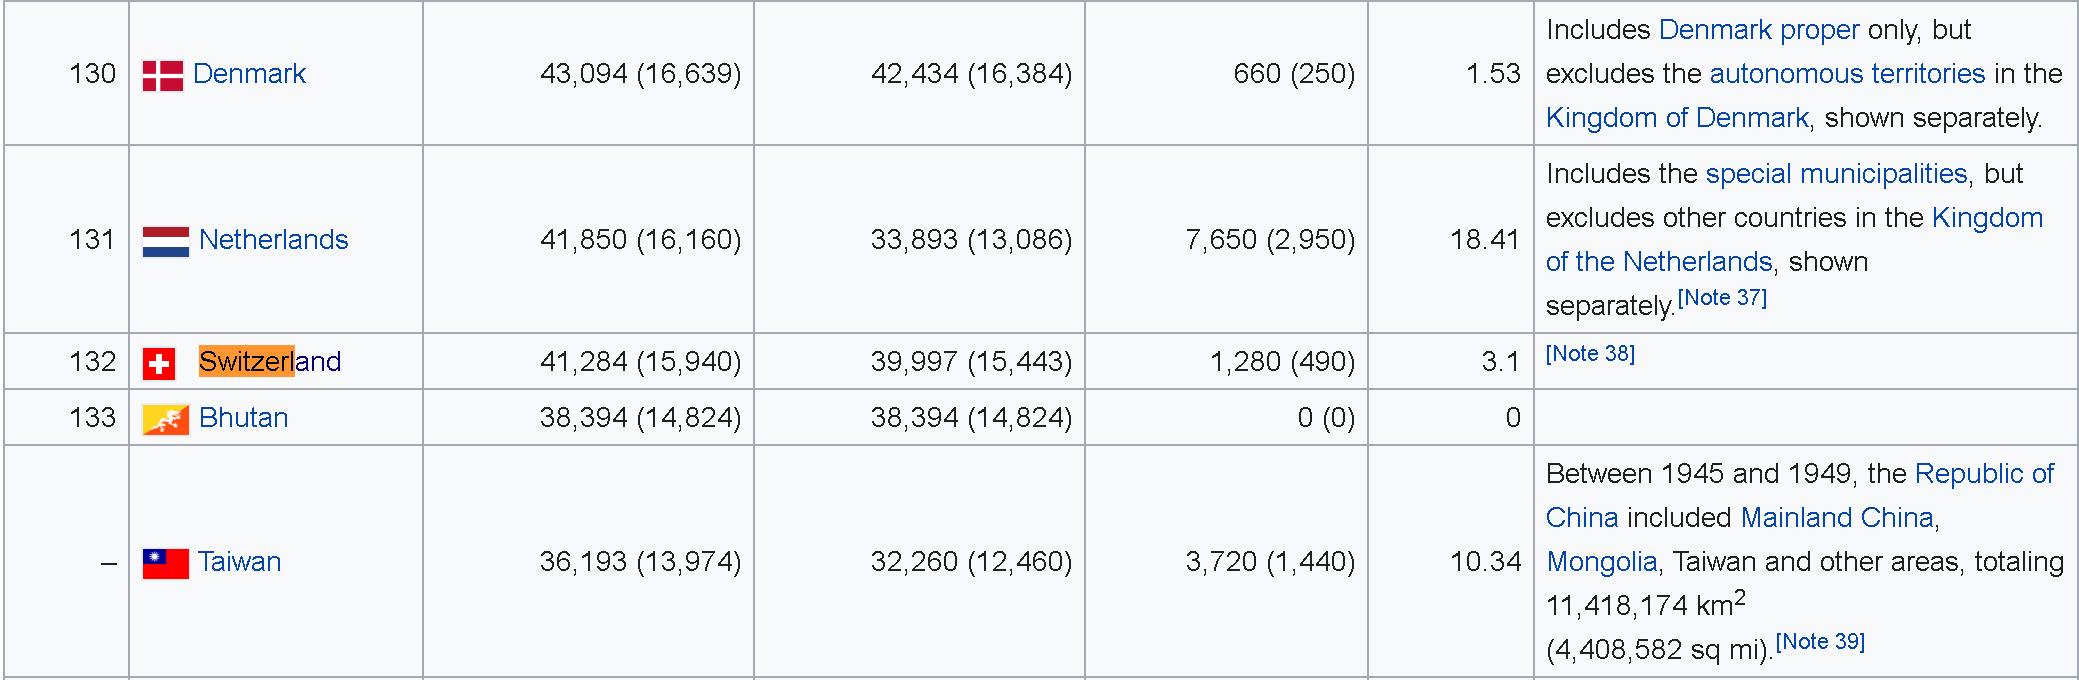

In [37]:
from IPython.display import Image
Image(filename='switzerland_similarsizes.png')

Ein Vergleich zwischen Flächenmässig gleichgrossen Ländern macht bereits mehr sinn. 

In [38]:
def lineplot_swiss_similar_countries(data):
    data = data.copy()
    data = data[data['country'].isin(['Switzerland','Denmark', 'Netherlands', 'Bhutan', 'Taiwan']) == True]
    data = data.pivot_table(index='date', columns='country', values='temperature')
    data = data.loc['1800':]
    data = data.resample('5Y').mean()
                
    fig = go.Figure()
    
    for column in data.columns:
        if column != 'Switzerland':
            fig.add_trace(go.Scatter(x=data.index,
                                     y=data[column], 
                                     name=column,
                                     line=dict(color='red'),
                                     opacity=0.1)
                         )
        else:
            fig.add_trace(go.Scatter(x=data.index,
                                     y=data[column],
                                     name=column, 
                                     line=dict(color='red',
                                               width=2)
                                    )
                         )
    fig.add_trace(go.Scatter(x=data.index,
                             y=[0 for i in range(data.shape[0])],
                             name='Mittelwert von 1950-1980',
                             line=dict(color='black', 
                                       dash='dot',
                                       width=1),
                             opacity=0.8)
                  
                 )
    
    fig.update_layout(template='simple_white',
                      title='Temperaturdifferenzen zum gemessenen Mittel ähnlich grosser Länder zur Schweiz von 1950-1980',
                      xaxis_title='Jahre',
                      yaxis_title='Temperaturdifferenz in K',
                     )
    
    fig.update_layout(width=950,
                    margin_b=90, 
                    annotations = [dict(xref='paper',
                                        yref='paper',
                                        x=0.5, y=-0.25,
                                        showarrow=False,
                                        text ='Quelle: http://berkeleyearth.org/')])
                      

    fig.show()
    
    
lineplot_swiss_similar_countries(temp_data)

Ihn interessier nun der maximale Absolute Unterschied vom Anfangsmesswert zum letzten gemessenen Messwert jedes Landes. Welches Land hatte den grössten Zuwachs und wie steht die Schweiz zu diesen Ländern?

In [39]:
def barchart_top_flop(data):
    
    data = data.pivot_table(index='date', columns=data['country'], values='temperature')
    
    data = data.resample('10Y').mean()
    data = data.fillna(method='backfill')

    diff = data.iloc[-1, :] - data.iloc[0, :]
    temp = data.iloc[0, :]
    data = pd.concat([temp, data.iloc[-1,:]], axis=1).T
        
    top_diff = diff.sort_values(ascending=False).iloc[:10].reset_index()['country'].values
    flop_diff = diff.sort_values(ascending=True).iloc[:10].reset_index()['country'].values
    
    top_diff = np.append(top_diff, 'Switzerland')
    
    top_diff = data[data.columns.intersection(top_diff)].T
    flop_diff = data[data.columns.intersection(flop_diff)].T
    
    top_diff['top_low'] = 'top'
    flop_diff['top_low'] = 'low'
    
    data = pd.concat([top_diff, flop_diff], axis=0)
    data.columns = [data.columns[0].year, data.columns[1].year, 'top_low']
    data.loc['Switzerland', 'top_low'] = 'neutral'
    data['diff'] = data[2013] - data[1743]
    data = data.sort_values(by=['top_low', 'diff'], ascending=True)
    
    
    fig = go.Figure()
    
    for i in range(len(data.index)):
        if data.loc[data.index[i], 'top_low'] == 'top':
            fig.add_trace(go.Bar(
                                y=[data.loc[data.index[i], 'diff']],
                                x=[data.index[i]],
                                marker=dict(
                                    color='red'
                                ),
                                opacity=0.5
                                )
                         )
            
        if data.loc[data.index[i], 'top_low'] == 'low':
            fig.add_trace(go.Bar(
                                y=[data.loc[data.index[i], 'diff']],
                                x=[data.index[i]],
                                marker=dict(
                                    color='blue'
                                ),
                                opacity=0.5
                         ))
            
        if data.loc[data.index[i], 'top_low'] == 'neutral':
            fig.add_trace(go.Bar(
                                y=[data.loc[data.index[i], 'diff']],
                                x=[data.index[i]],
                                marker=dict(
                                    color='grey'
                                )
                                ))
 
    
    fig.update_layout(template='simple_white',
                      title='Highest 10 / Lowest 10 Temperature Differences since Start Measurement',
                      showlegend=False, 
                      xaxis_title='Temperature Difference in K',
                      yaxis=dict(
                          range=[-3.5, 3.5]
                          )
                     )
    fig.show()
    
barchart_top_flop(temp_data)

Jan weiss bereits das der Temperaturanstieg in der Schweiz ein grosses Problem ist nicht nur auf die Schneeschmelze bezogen.
Er weiss, auch das die globale Klimaerwärmung aufgrund des hohen CO2-Ausstosses von Industrieländern verschuldet ist. Mit diesem Wissen interessiert es ihn, wieviel die Schweiz im Verhältnis zum Weltweiten Ausstoss wirklich ausmacht. Dafür möchte er einen Grössenvergleich zwischen den Top-Reitern der CO2-ausstossreichsten Ländern und und der Schweiz wagen. Wieviel macht die Schweiz im Vergleich zu den emissionsreichsten Ländern wirklich aus?

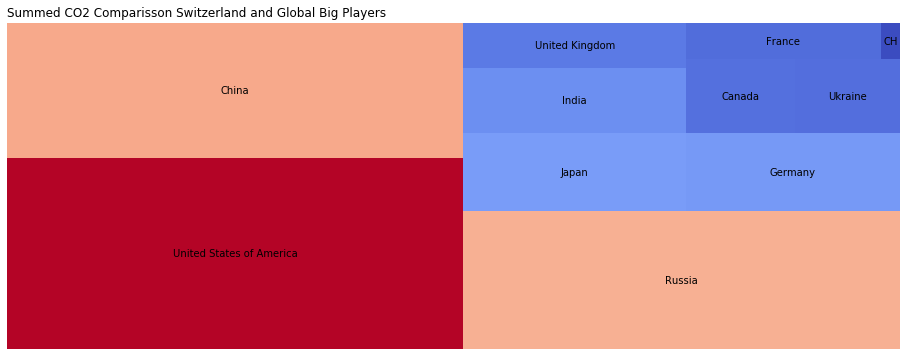

In [40]:
import matplotlib.pyplot as plt
import matplotlib
import squarify

def tree_map_co2(data):
    data = data.copy()
    data = data.groupby('country').sum()
    data_swiss = data[data.index == 'Switzerland']
    data_swiss.index = ['CH']
    top_players = data.sort_values('co2', ascending=False).iloc[:10]
    top_players = pd.concat([top_players, data_swiss], axis=0)
    
    # Plotting
    cmap = matplotlib.cm.coolwarm
    mini=min(top_players['co2'])
    maxi=max(top_players['co2'])
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in top_players['co2']]
 
    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=top_players['co2'] , label=top_players.index, color=colors)
    plt.title('Summed CO2 Comparisson Switzerland and Global Big Players', loc='left')
    plt.axis('off')
    plt.show()
    
tree_map_co2(co2_data)

Ich wusste, dass die Länder mit denen er den CO2-Ausstoss vergleicht von der grösse her sehr stark divergieren. Umso grösser das Land, desto grösser der Klimausstoss. Es zeichnet sich auch so ab, dass die wirtschaftlich stärksten Länder eigentlich alle in disem Top-Ranking dabei sind. Die Schweiz belegt also im globalen CO2-Ausstoss eher einer der hinteren Plätze, obwohl die Wirtschaft in der Schweiz gemessen am BIP relativ stark ist. Wie wir sehen können ist sie auch im Vergleich zu den emissionsreichsten Ländern kein Vergleichsmass.

In [41]:
def scatter_temp_co2(co2, temp):
    
    co2 = co2.copy()
    co2 = co2[['country', 'continent', 'co2']].groupby(['continent', 'country']).sum()
    co2 = co2.reset_index()
    
    temp = temp.copy()
    temp = temp[['country', 'continent', 'temperature']].groupby(['continent', 'country']).median()
    temp = temp.reset_index()
    
    data = pd.merge(left=co2, right=temp, how='inner',
                    left_on=['country'], right_on=['country'])
    
    data['display_name'] = np.where(data['co2'] > 23000, data['country'], '')
    
    fig = px.scatter(x=data['temperature'], 
                     y=data['co2'],
                     color=data['continent_y'],
                     color_discrete_sequence=px.colors.qualitative.Set1,
                     text=data['display_name'],
                     size=data['co2'])
    
    fig.update_traces(textposition='top center')
    
    fig.update_layout(template='simple_white',  
                      title='Temperaturdifferenz vs CO2-Emissionen',
                      xaxis_title='Median Temperatur Anomalie (K)',
                      yaxis_title='Summierte CO2-Emissionen (Megatonnen)')
    fig.show()

In [43]:
scatter_temp_co2(co2_data, temp_data)